# Degrading a simulated data set in a controlled way

This notebook shows how to use two basic degraders together with a creator to generate degraded data sets.

In [1]:
from pzflow.examples import example_flow
from rail.creation import Creator, engines
from rail.creation.degradation import InvRedshiftIncompleteness, LineConfusion
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches

Found classifier FZBoost
Found classifier randomPZ
Found classifier simpleNN
Found classifier trainZ


First, we will demonstrate the `InvRedshiftIncompleteness` degrader. It applies a selection function, which keeps galaxies with probability $p_{\text{keep}}(z) = \min(1, \frac{z_p}{z})$, where $z_p$ is the ''pivot'' redshift. We'll use $z_p = 0.8$.

Let's create a samples from a creator with and without this selection function, and compare their redshift distributions.

In [2]:
flow = engines.FlowEngine(example_flow())
creator = Creator(flow)
degraded_creator = Creator(flow, degrader=InvRedshiftIncompleteness(0.8))

In [3]:
samples = creator.sample(100000)
degraded_samples = degraded_creator.sample(100000)

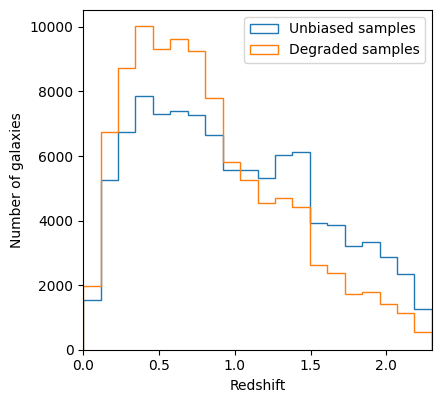

In [4]:
fig, ax = plt.subplots(figsize=(4.5,4.5), dpi=100)
ax.hist(samples['redshift'], bins=20, range=(0,2.3), histtype='step', label="Unbiased samples")
ax.hist(degraded_samples['redshift'], bins=20, range=(0,2.3), histtype='step', label="Degraded samples")
ax.legend()
ax.set(xlabel="Redshift", ylabel="Number of galaxies", xlim=(0,2.3))
plt.show()

We can see that the biased samples have more low redshift galaxies, and a deficit of galaxies with redshift > 1.

Also note that, despite the selection function, both sets have the same number of galaxies:

In [5]:
degraded_samples.shape == samples.shape

True

This is because the creator keeps re-sampling and applying the selection function until it has the same number of samples you requested when you called `creator.sample()`

Now, let's demonstrate `LineConfusion`. This is a degrader that simulates spectroscopic errors resulting from the confusion of different emission lines.

Let's use the `LineConfusion` degrader to create an `OxygenLineConfusion` degrader, in which 2% of [OII] lines are mistaken as [OIII] lines, and 1% of [OIII] lines are mistaken as [OII] lines.

Again, we will make samples with and without this degradation, this time comparing the spec-z's

In [6]:
def OxygenLineConfusion(data, seed=None):
    OII = 3727
    OIII = 5007
    
    data = LineConfusion(true_wavelen=OII, wrong_wavelen=OIII, frac_wrong=0.02)(data, seed)
    data = LineConfusion(true_wavelen=OIII, wrong_wavelen=OII, frac_wrong=0.01)(data, seed)
    return data

In [7]:
flow = engines.FlowEngine(example_flow())
creator = Creator(flow)
degraded_creator = Creator(flow, degrader=OxygenLineConfusion)

In [8]:
samples = creator.sample(100000, seed=0)
degraded_samples = degraded_creator.sample(100000, seed=0)

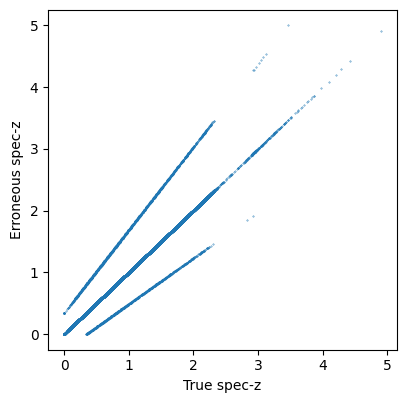

In [9]:
fig, ax = plt.subplots(figsize=(4.5,4.5), dpi=100)
ax.scatter(samples["redshift"], degraded_samples["redshift"], s=0.1)
ax.set(xlabel="True spec-z", ylabel="Erroneous spec-z")
plt.show()

The galaxies above the line y=x are the [OII] -> [OIII] galaxies, while the ones below are the [OIII] -> [OII] galaxies.